# Multi-layer Perceptron
mRNA data.    
Middle exclusion applied to the train set only.   
Or middle exclusion applied to the test set only.   

The "ForRNAlight" data files were generated by RNAlight_133.
Similar code was used to test RNAlight and LightGBM in RNAlight_137.
Similar code was used to test Random Forest in RF_201.

In [1]:
import time
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())

2024-06-05 20:03:11.830908
Python 3.10.12


In [2]:
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import warnings
import sklearn
import joblib
print('sklearn',sklearn.__version__)
print('Done')

sklearn 1.2.2
Done


In [3]:
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx('float32')
print(SEED)

100


In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
print('Done')

Done


In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
print('Done')

Done


In [6]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/RNAlight/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/RNAlight/'  # must end in "/"
    output_dir=PATH+'My Drive/data/Localization/RNAlight/'
except:
    IN_COLAB = False
    DATA_DIR = './'    # Mac
    MODEL_DIR = './'    # Mac
    output_dir = './'
print('DATA DIR', DATA_DIR)

Running on CoLab
Mounted at /content/drive/
DATA DIR /content/drive/My Drive/data/Localization/RNAlight/


In [8]:
def build_model():
    SHAPE = 1344   # empirically from array of k-mer profiles
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype='float32',input_dim=SHAPE)  # input_dim to be determined
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [9]:
test = build_model()
print(test)
test = None

In [10]:
class stats_collector:
    def __init__(self):
        self.reset_statistics()
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_mcc=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
    def _append_statistics(self,accuracy,precision,recall,f1,mcc,auprc,auroc):
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)
    def compute_performance(self,y_test,yhat_pred,yhat_classes,verbose=False):
        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        self._append_statistics(accuracy,precision,recall,f1,mcc,auprc,auroc)
        if verbose:
            self._show_confusion(y_test,yhat_pred,yhat_classes)
            self._show_statistics(accuracy,precision,recall,f1,mcc,auprc,auroc)
    def _show_confusion(self,y_test,yhat_pred,yhat_classes):
            print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            cm1 = confusion_matrix(y_test,yhat_classes)
            print('Confusion matrix\n',cm1)
            cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
            print('Normalized matrix\n',cm2)
    def _show_statistics(self,accuracy,precision,recall,f1,mcc,auprc,auroc):
            print('accuracy:',accuracy,'precision:',precision,'recall:',recall,\
                  'F1:',f1,'MCC:',mcc,'AUPRC:',auprc,'AUROC:',auroc)
    def _show_variance(self, name, stats_list):
        if name=='MCC':
            print('%10s %5.3f mean, %6.3f stdev' % (name,np.mean(stats_list),np.std(stats_list) ) )
        else:
            print('%10s %5.2f mean, %6.3f stdev' % (name,np.mean(stats_list),np.std(stats_list) ) )
        print(stats_list)
    def dump_all(self):
        self._show_variance('accuracy', self.cv_accuracy)
        self._show_variance('precision',self.cv_precision)
        self._show_variance('recall',   self.cv_recall)
        self._show_variance('F1',       self.cv_f1)
        self._show_variance('MCC',      self.cv_mcc)
        self._show_variance('AUPRC',    self.cv_auprc)
        self._show_variance('AUROC',    self.cv_auroc)

In [11]:
# From RNAlight notebook
def _count_kmer(Dataset,k): # k = 3,4,5

    # copy dataset
    dataset = copy.deepcopy(Dataset)
    # alphbet of nucleotide
    nucleotide = ['A','C','G','T']

    # generate k-mers
    #  k == 5:
    five = list(itertools.product(nucleotide,repeat=5))
    pentamer = []
    for n in five:
        pentamer.append("".join(n))

    #  k == 4:
    four = list(itertools.product(nucleotide,repeat=4))
    tetramer = []
    for n in four:
        tetramer.append("".join(n))

    # k == 3:
    three = list(itertools.product(nucleotide,repeat=3))
    threemer = []
    for n in three:
        threemer.append("".join(n))

    # input features can be combinations of diffrent k values
    if k == 34:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
    if k == 45:
        table_kmer = dict.fromkeys(tetramer,0)
        table_kmer.update(dict.fromkeys(pentamer,0))
    if k == 345:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
        table_kmer.update(dict.fromkeys(pentamer,0))

    # count k-mer for each sequence
    for mer in table_kmer.keys():
        table_kmer[mer] = dataset["cdna"].apply(lambda x : x.count(mer))

    # for k-mer raw count without normalization, index: nuc:1 or cyto:0
    rawcount_kmer_df = pd.DataFrame(table_kmer)
    df1_rawcount = pd.concat([rawcount_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1_rawcount.index = dataset["tag"]

    # for k-mer frequency with normalization , index: nuc:1 or cyto:0
    freq_kmer_df = rawcount_kmer_df.apply(lambda x: x/x.sum(),axis=1)
    df1 = pd.concat([freq_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1.index = dataset["tag"]

    return df1  # ,df1_rawcount

In [12]:
# From RNAlight notebook
def load_dataframe(cyto_f,nuc_f,cyto_mid_f,nuc_mid_f):
    print('load dataframe')
    dataset_cyto = pd.read_csv(cyto_f,sep='\t',index_col = False)
    dataset_nuc = pd.read_csv(nuc_f,sep='\t',index_col = False)
    print( len(dataset_cyto), 'cytoplasmic samples')
    print( len(dataset_nuc),  'nuclear samples')
    middle_cyto = pd.read_csv(cyto_mid_f,sep='\t',index_col = False)
    middle_nuc = pd.read_csv(nuc_mid_f,sep='\t',index_col = False)
    print( len(middle_cyto), 'cytoplasmic middle samples')
    print( len(middle_nuc),  'nuclear middle samples')
    return dataset_cyto,dataset_nuc,middle_cyto,middle_nuc

In [13]:
# Added
def rebalance(dataset_cyto,dataset_nuc):
    print('sample down to balance classes')
    min_size = min(len(dataset_cyto),len(dataset_nuc))
    # random sampling without replacement
    dataset_cyto = dataset_cyto.sample(min_size, random_state=SEED)
    dataset_nuc  = dataset_nuc.sample(min_size,  random_state=SEED)
    print( len(dataset_cyto), 'cytoplasmic samples')
    print( len(dataset_nuc),  'nuclear samples')
    return dataset_cyto,dataset_nuc

In [14]:
PERMANENT_NUC = 1
PERMANENT_CYTO = 0
INDICATOR_NUC = 2
INDICATOR_CYTO = -2
# From RNAlight notebook
def extract_features_and_split(dataset_cyto,dataset_nuc,middle_cyto,middle_nuc):
    print('add labels, concatenate')
    # Set the tag of RCI(log2FC): nuclear 1 / cytosol 0
    #dataset_nuc['tag'] = 1;dataset_cyto['tag'] = 0
    dataset_nuc['tag'] = PERMANENT_NUC;dataset_cyto['tag'] = PERMANENT_CYTO
    middle_nuc['tag'] = INDICATOR_NUC;middle_cyto['tag'] = INDICATOR_CYTO
    # merge the datasets
    dataset = pd.concat([dataset_nuc,dataset_cyto])
    dataset = pd.concat([dataset,middle_nuc])
    dataset = pd.concat([dataset,middle_cyto])

    print('dedupe (probably not necessary)')
    # remove duplications(actually,each RNA is unique in its class)
    dataset.drop_duplicates(keep="first",subset=["ensembl_transcript_id","name","cdna"],inplace=True)

    print('count kmers')
    # k = 3,4,5 count the normalized and raw count of kmer
    df_kmer_345 = _count_kmer(dataset,345)   # df_kmer_345,df_kmer_345_rawcount =

    # We commented this out. No need to save the tsv.
    # df_kmer_345.to_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t')
    # This was commented out in the original. Seems they reran using saved kmers. Should test if file exists.
    # load kmer file
    # df_kmer_345 = pd.read_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t',index_col= 0)

    # convert to x:kmer-freq , y:label
    del df_kmer_345['ensembl_transcript_id']
    x_kmer = df_kmer_345.values
    y_kmer = y_kmer = np.array(df_kmer_345.index)

    # split into training and test sets (9:1)
    print('train/test split')
    x_train, x_test, y_train, y_test = train_test_split(x_kmer, y_kmer, test_size = 0.1, random_state = SEED)

    #print('Apply cross-validation to all the data (no test set withheld)')
    #x_train, x_test, y_train, y_test = train_test_split(x_kmer, y_kmer, test_size = None, random_state = SEED)
    print('train set shape',x_train.shape)
    # Added
    labels,counts = np.unique(y_train,return_counts=True)
    print('train set labels', labels, 'counts',counts)
    labels,counts = np.unique(y_test,return_counts=True)
    print('test set labels', labels, 'counts',counts)
    return x_train, x_test, y_train, y_test

In [15]:
TRAIN_MODE='train'
VALID_MODE='valid'
def do_cv(x_train, y_train, exclusion_mode):
    stats = stats_collector()
    for round in range(1,3):   # RESTORE TO RANGE(1,3)
        fold=0
        splitter = KFold(n_splits=5)  # RESTORE TO SPLITS=5
        for train_index, valid_index in splitter.split(x_train):
            fold += 1
            print('Round', round, 'Fold', fold)
            print('Train')
            lgb = build_model()
            print('Num samples in training set:', len(x_train), len(y_train))
            x_reduced = x_train[train_index]
            y_reduced = y_train[train_index]
            print('Num train samples in this fold:', len(x_reduced), len(y_reduced))
            exclusions = []
            for i in range(len(y_reduced)):
                if y_reduced[i] == INDICATOR_NUC:
                    if exclusion_mode==TRAIN_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_NUC
                elif y_reduced[i] == INDICATOR_CYTO:
                    if exclusion_mode==TRAIN_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_CYTO
            print('Num exclusions:', len(exclusions))
            if len(exclusions)>0:
                x_reduced = np.delete(x_reduced,exclusions,axis=0)
                y_reduced = np.delete(y_reduced,exclusions,axis=0)
            print('Num train samples after exclusion:', len(x_reduced), len(y_reduced))
            history = lgb.fit(x_reduced, y_reduced,
                             epochs=150, verbose=0)  # RESTORE TO EPOCHS 300?
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Validate')
            x_reduced = x_train[valid_index]
            y_reduced = y_train[valid_index]
            print('Num validation samples in this fold:', len(x_reduced), len(y_reduced))
            exclusions = []
            for i in range(len(y_reduced)):
                if y_reduced[i] == INDICATOR_NUC:
                    if exclusion_mode==VALID_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_NUC
                elif y_reduced[i] == INDICATOR_CYTO:
                    if exclusion_mode==VALID_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_CYTO
            print('Num exclusions:', len(exclusions))
            if len(exclusions)>0:
                x_reduced = np.delete(x_reduced,exclusions,axis=0)
                y_reduced = np.delete(y_reduced,exclusions,axis=0)
            print('Num validation samples after exclusion:', len(x_reduced), len(y_reduced))
            yhat_pred=lgb.predict(x_reduced, verbose=0)
            yhat_classes=np.where(yhat_pred > 0.5, 1, 0)
            #yhat_classes= lgb.predict(x_valid)  # get 0 or 1
            #yhat_pairs=   lgb.predict_proba(x_valid)  # get [ prob of 0, prob of 1 ]
            #yhat_pred=    [pair[1] for pair in yhat_pairs]
            stats.compute_performance(y_reduced,yhat_pred,yhat_classes,verbose=False)
    return stats

middle exclusion on training set only
Data files:
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIgt0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIlt-2.canonical.tsv
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCI-1to0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCI-2to-1.canonical.tsv
load dataframe
7909 cytoplasmic samples
987 nuclear samples
4854 cytoplasmic middle samples
2431 nuclear middle samples
Rebalance (sample down the majority class) and repeat
sample down to balance classes
987 cytoplasmic samples
987 nuclear samples
sample down to balance classes
2431 cytoplasmic samples
2431 nuclear samples
add labels, concatenate
dedupe (probably not necessary)
count kmers
train/test split
train set shape (6152, 1344)
train set labels [-2  0  1  2] counts [2189  889  898 2176]
test set labels [-2  0  1  2] counts [242  98  89 255]
Round 1 Fold 1
Train
Num samp

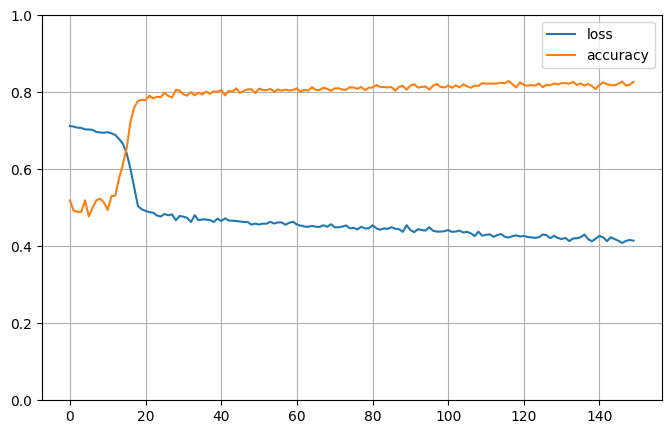

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 0
Num validation samples after exclusion: 1231 1231
Round 1 Fold 2
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4921 4921
Num exclusions: 3489
Num train samples after exclusion: 1432 1432


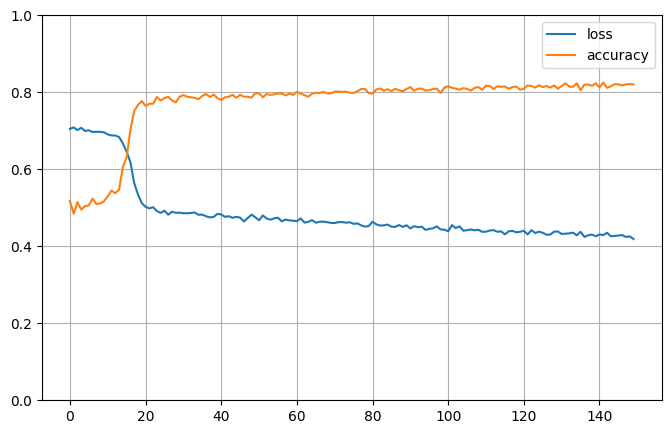

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 0
Num validation samples after exclusion: 1231 1231
Round 1 Fold 3
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 3514
Num train samples after exclusion: 1408 1408


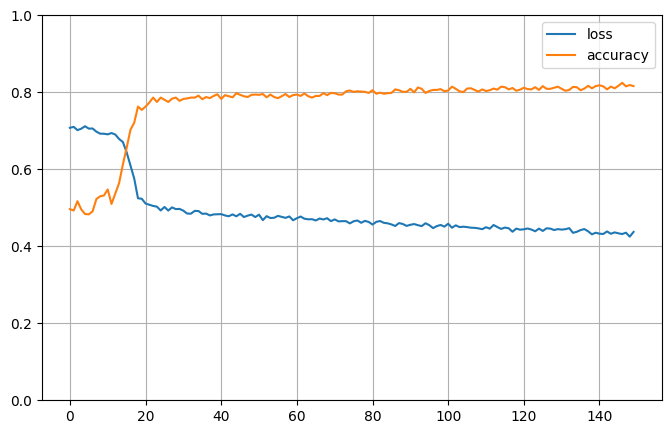

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 0
Num validation samples after exclusion: 1230 1230
Round 1 Fold 4
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 3469
Num train samples after exclusion: 1453 1453


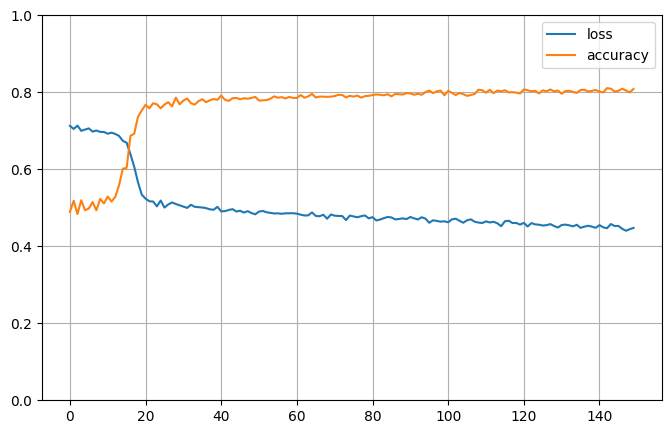

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 0
Num validation samples after exclusion: 1230 1230
Round 1 Fold 5
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 3485
Num train samples after exclusion: 1437 1437


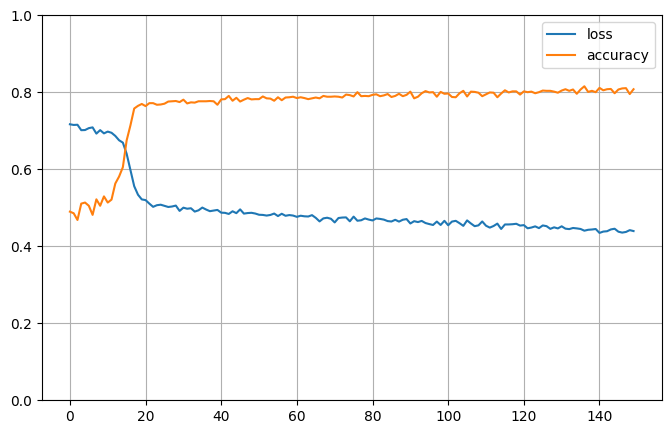

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 0
Num validation samples after exclusion: 1230 1230
Round 2 Fold 1
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4921 4921
Num exclusions: 3503
Num train samples after exclusion: 1418 1418


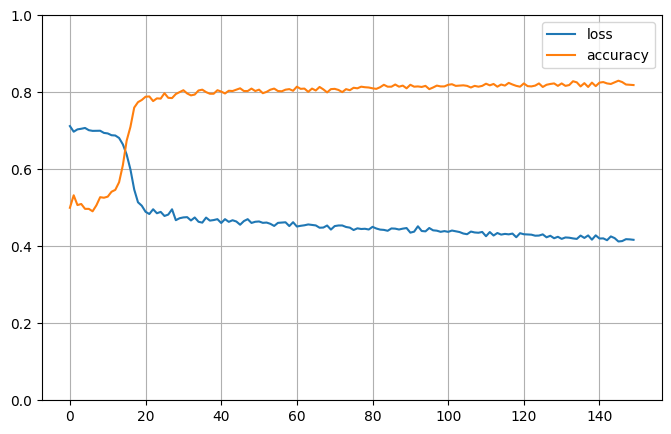

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 0
Num validation samples after exclusion: 1231 1231
Round 2 Fold 2
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4921 4921
Num exclusions: 3489
Num train samples after exclusion: 1432 1432


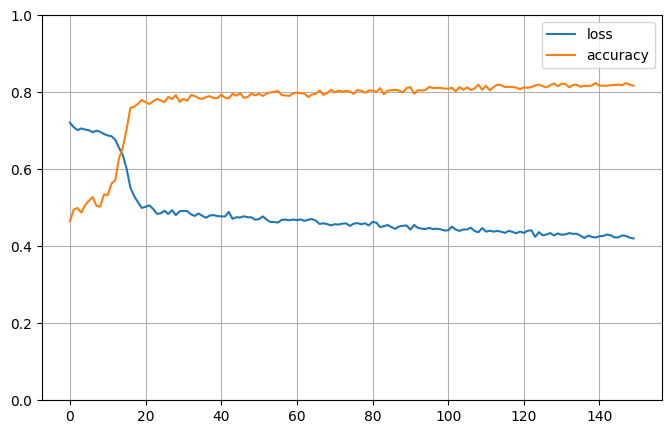

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 0
Num validation samples after exclusion: 1231 1231
Round 2 Fold 3
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 3514
Num train samples after exclusion: 1408 1408


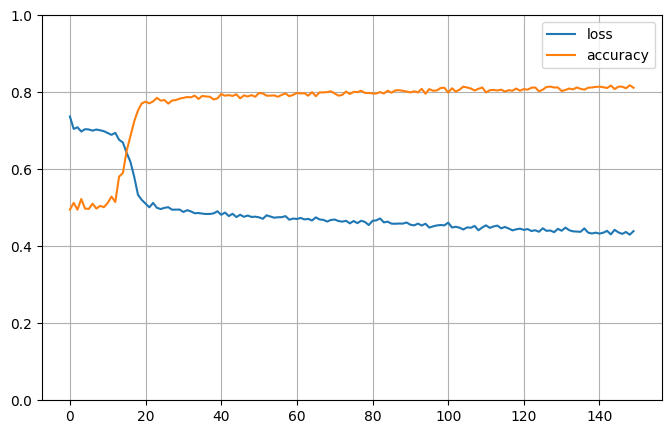

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 0
Num validation samples after exclusion: 1230 1230
Round 2 Fold 4
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 3469
Num train samples after exclusion: 1453 1453


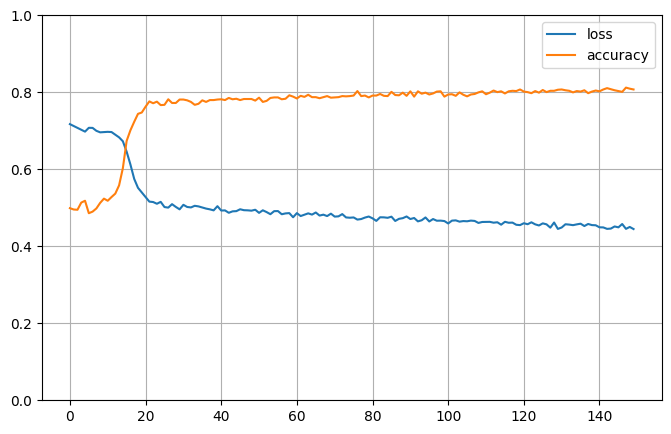

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 0
Num validation samples after exclusion: 1230 1230
Round 2 Fold 5
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 3485
Num train samples after exclusion: 1437 1437


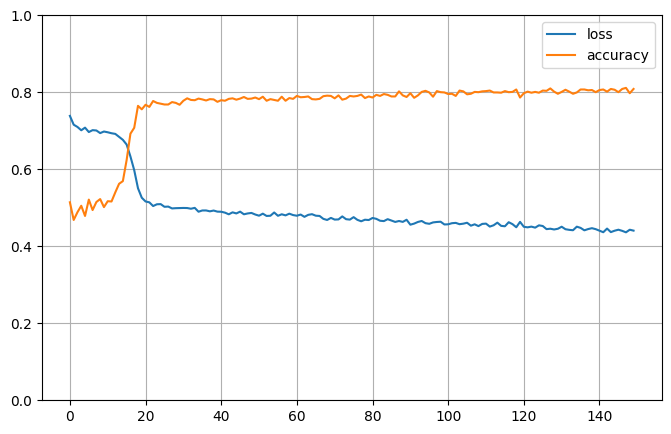

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 0
Num validation samples after exclusion: 1230 1230

Cross validation results
  accuracy 64.89 mean,  1.649 stdev
[62.55077173030057, 64.66287571080423, 67.15447154471545, 66.09756097560975, 64.47154471544717, 61.9821283509342, 64.66287571080423, 67.15447154471545, 65.85365853658537, 64.3089430894309]
 precision 63.67 mean,  2.370 stdev
[59.383378016085786, 63.85737439222042, 65.7514450867052, 64.83679525222553, 65.086887835703, 58.80794701986755, 63.85737439222042, 65.70605187319885, 64.4640234948605, 64.92890995260665]
    recall 69.71 mean,  3.750 stdev
[73.71048252911814, 65.01650165016501, 73.15112540192926, 70.82658022690438, 65.60509554140127, 73.87687188019967, 65.01650165016501, 73.31189710610933, 71.15072933549432, 65.44585987261146]
        F1 66.46 mean,  1.770 stdev
[65.7757980697847, 64.43172526573997, 69.25418569254187, 67.69945778466305, 65.34496431403647, 65.48672566371681, 64.43172526573997, 69.30

In [16]:
if True:   # middle exclusion on training set only
    print('middle exclusion on training set only')
    cyto_f = DATA_DIR+'ForRNAlight.mRNA_RCIgt0.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.mRNA_RCIlt-2.canonical.tsv'
    cyto_mid_f = DATA_DIR+'ForRNAlight.mRNA_RCI-1to0.canonical.tsv'
    nuc_mid_f  = DATA_DIR+'ForRNAlight.mRNA_RCI-2to-1.canonical.tsv'
    print('Data files:')
    print(cyto_f,'\n',nuc_f)
    print(cyto_mid_f,'\n',nuc_mid_f)
    dataset_cyto,dataset_nuc,middle_cyto,middle_nuc = load_dataframe(cyto_f,nuc_f,cyto_mid_f,nuc_mid_f)
    print('Rebalance (sample down the majority class) and repeat')
    dataset_cyto,dataset_nuc = rebalance(dataset_cyto,dataset_nuc)
    middle_cyto,middle_nuc = rebalance(middle_cyto,middle_nuc)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc,middle_cyto,middle_nuc)
    stats = do_cv(x_train, y_train, TRAIN_MODE)
    print('\nCross validation results')
    stats.dump_all()

middle exclusion on validation set only
Data files:
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIgt0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIlt-2.canonical.tsv
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCI-1to0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCI-2to-1.canonical.tsv
load dataframe
7909 cytoplasmic samples
987 nuclear samples
4854 cytoplasmic middle samples
2431 nuclear middle samples
Rebalance (sample down the majority class) and repeat
sample down to balance classes
987 cytoplasmic samples
987 nuclear samples
sample down to balance classes
2431 cytoplasmic samples
2431 nuclear samples
add labels, concatenate
dedupe (probably not necessary)
count kmers
train/test split
train set shape (6152, 1344)
train set labels [-2  0  1  2] counts [2189  889  898 2176]
test set labels [-2  0  1  2] counts [242  98  89 255]
Round 1 Fold 1
Train
Num sa

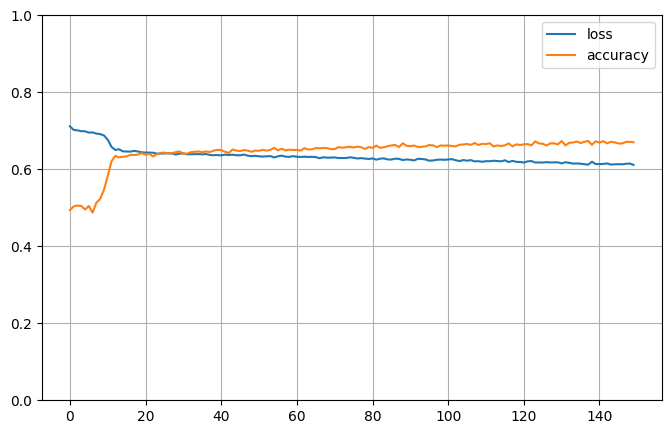

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 862
Num validation samples after exclusion: 369 369
Round 1 Fold 2
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4921 4921
Num exclusions: 0
Num train samples after exclusion: 4921 4921


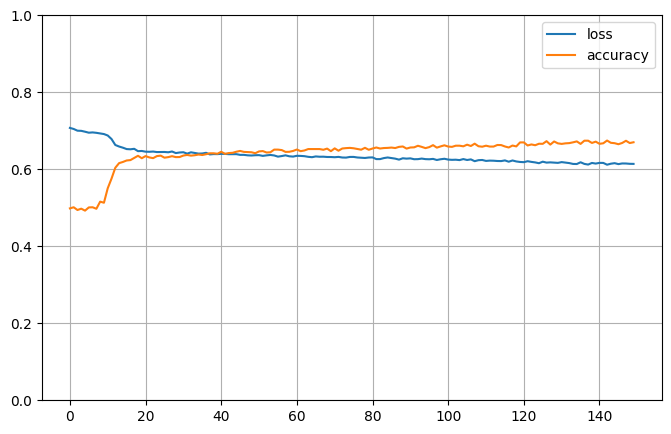

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 876
Num validation samples after exclusion: 355 355
Round 1 Fold 3
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 0
Num train samples after exclusion: 4922 4922


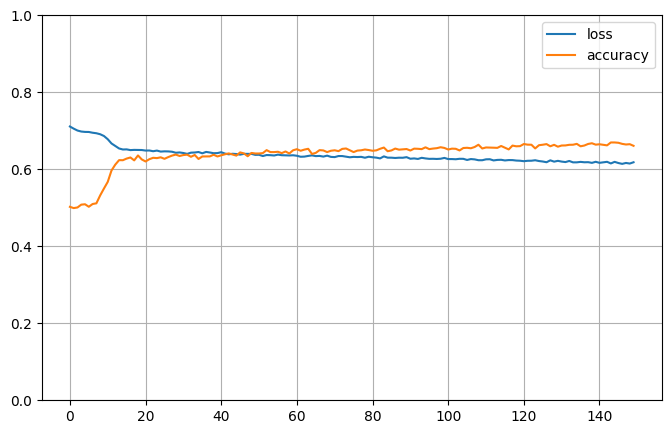

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 851
Num validation samples after exclusion: 379 379
Round 1 Fold 4
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 0
Num train samples after exclusion: 4922 4922


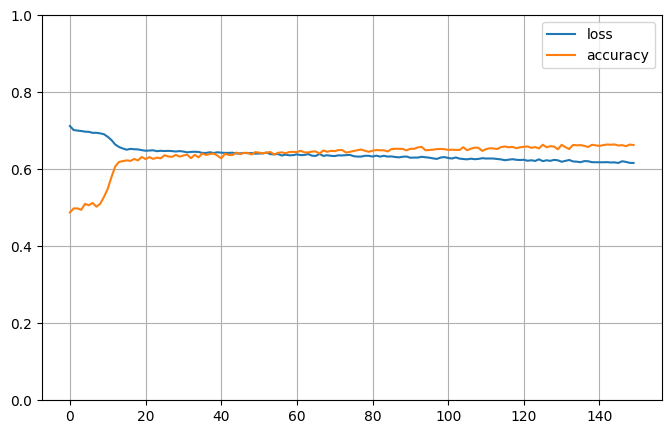

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 896
Num validation samples after exclusion: 334 334
Round 1 Fold 5
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 0
Num train samples after exclusion: 4922 4922


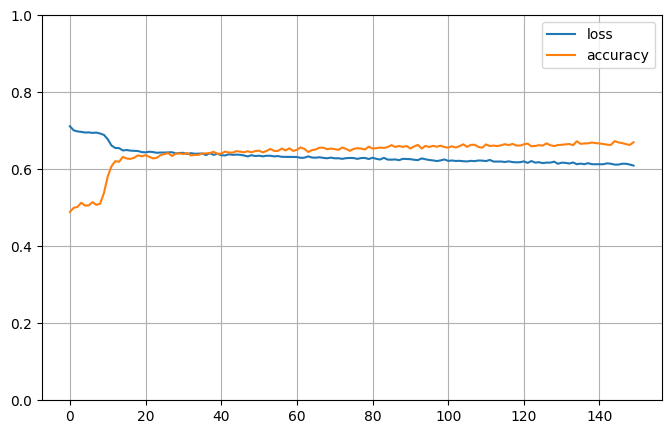

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 880
Num validation samples after exclusion: 350 350
Round 2 Fold 1
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4921 4921
Num exclusions: 0
Num train samples after exclusion: 4921 4921


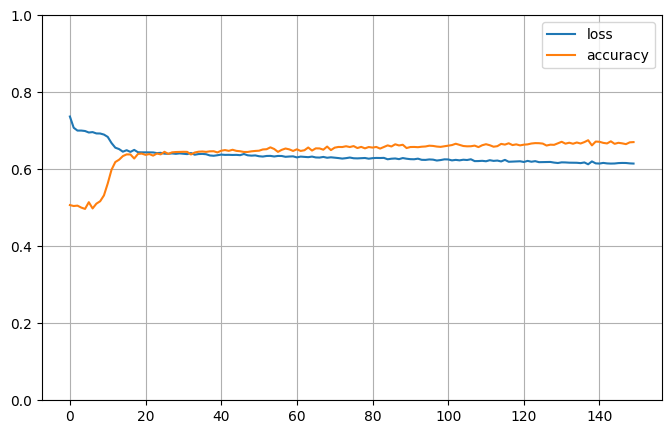

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 862
Num validation samples after exclusion: 369 369
Round 2 Fold 2
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4921 4921
Num exclusions: 0
Num train samples after exclusion: 4921 4921


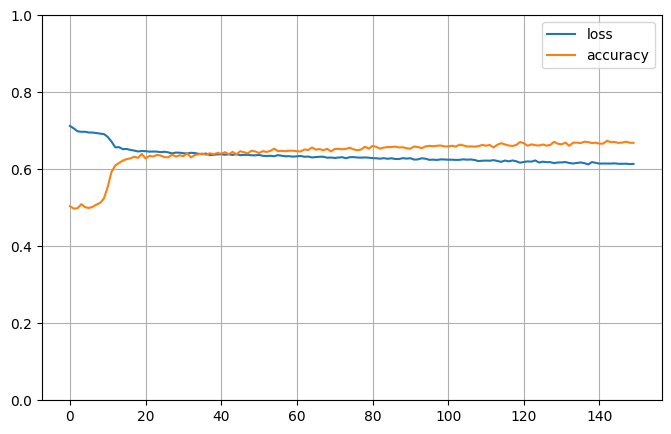

Validate
Num validation samples in this fold: 1231 1231
Num exclusions: 876
Num validation samples after exclusion: 355 355
Round 2 Fold 3
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 0
Num train samples after exclusion: 4922 4922


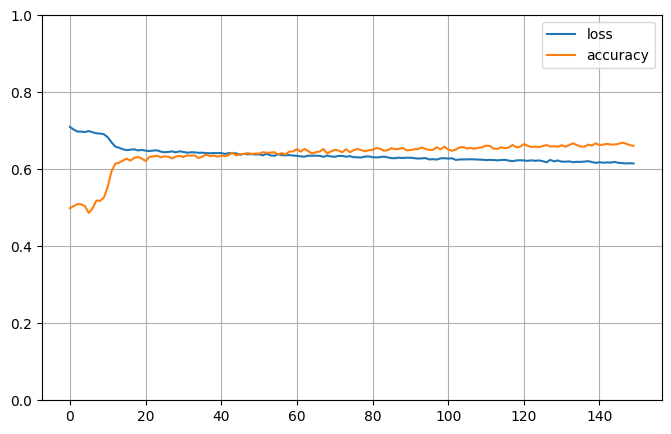

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 851
Num validation samples after exclusion: 379 379
Round 2 Fold 4
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 0
Num train samples after exclusion: 4922 4922


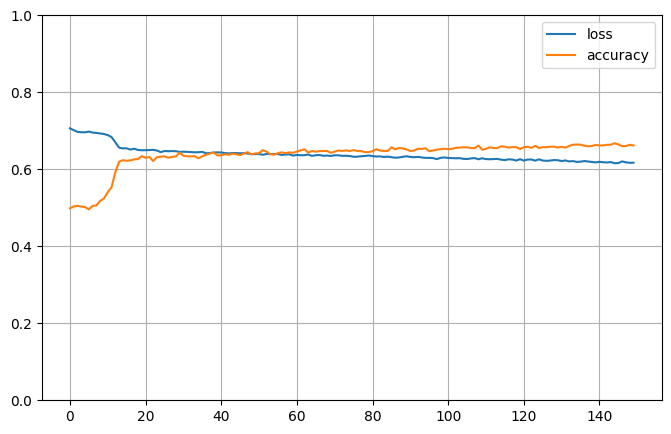

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 896
Num validation samples after exclusion: 334 334
Round 2 Fold 5
Train
Num samples in training set: 6152 6152
Num train samples in this fold: 4922 4922
Num exclusions: 0
Num train samples after exclusion: 4922 4922


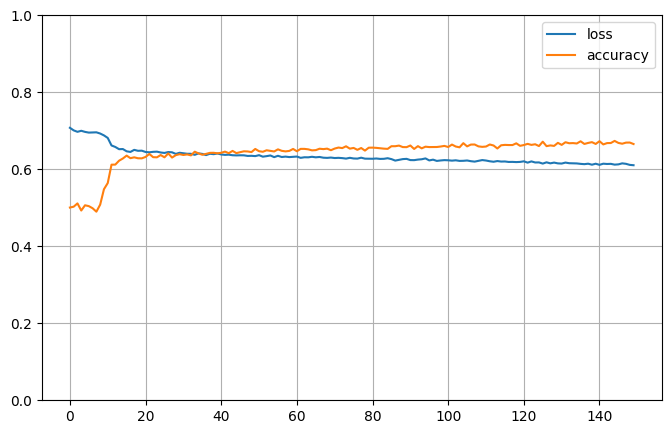

Validate
Num validation samples in this fold: 1230 1230
Num exclusions: 880
Num validation samples after exclusion: 350 350

Cross validation results
  accuracy 80.25 mean,  2.130 stdev
[78.31978319783198, 77.1830985915493, 81.53034300791556, 82.93413173652695, 81.42857142857143, 78.31978319783198, 77.1830985915493, 81.26649076517151, 82.63473053892216, 81.71428571428572]
 precision 85.00 mean,  4.721 stdev
[77.71739130434783, 83.9506172839506, 83.9080459770115, 90.76923076923077, 89.20863309352518, 77.71739130434783, 83.53658536585365, 82.68156424581005, 90.69767441860465, 89.85507246376811]
    recall 74.32 mean,  3.346 stdev
[78.57142857142857, 71.20418848167539, 77.6595744680851, 72.39263803680981, 71.26436781609196, 78.57142857142857, 71.72774869109948, 78.72340425531915, 71.77914110429448, 71.26436781609196]
        F1 79.12 mean,  1.337 stdev
[78.14207650273224, 77.05382436260622, 80.66298342541435, 80.54607508532423, 79.23322683706071, 78.14207650273224, 77.1830985915493, 80.65

In [17]:
if True:   # middle exclusion on validation set only
    print('middle exclusion on validation set only')
    cyto_f = DATA_DIR+'ForRNAlight.mRNA_RCIgt0.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.mRNA_RCIlt-2.canonical.tsv'
    cyto_mid_f = DATA_DIR+'ForRNAlight.mRNA_RCI-1to0.canonical.tsv'
    nuc_mid_f  = DATA_DIR+'ForRNAlight.mRNA_RCI-2to-1.canonical.tsv'
    print('Data files:')
    print(cyto_f,'\n',nuc_f)
    print(cyto_mid_f,'\n',nuc_mid_f)
    dataset_cyto,dataset_nuc,middle_cyto,middle_nuc = load_dataframe(cyto_f,nuc_f,cyto_mid_f,nuc_mid_f)
    print('Rebalance (sample down the majority class) and repeat')
    dataset_cyto,dataset_nuc = rebalance(dataset_cyto,dataset_nuc)
    middle_cyto,middle_nuc = rebalance(middle_cyto,middle_nuc)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc,middle_cyto,middle_nuc)
    stats = do_cv(x_train, y_train, VALID_MODE)
    print('\nCross validation results')
    stats.dump_all()

In [18]:
print(datetime.now())
print('Done')

2024-06-05 20:24:29.627093
Done
